In [1]:
import pickle
import numpy as np

In [2]:
with open('train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
type(train_data)

list

In [5]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [6]:
len(train_data)

10000

In [7]:
all_data = train_data + test_data

In [8]:
len(all_data)

11000

In [9]:
vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [10]:
vocab.add('no')
vocab.add('yes')

In [11]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [12]:
vocab_len = len(vocab) + 1

In [13]:
all_story_lens = [len(data[0]) for data in all_data]
max_story_lens = max(all_story_lens)

In [46]:
max_story_lens

156

In [14]:
all_question_lens = [len(data[1]) for data in all_data]
max_question_lens = max(all_question_lens)

In [15]:
max_question_lens

6

In [16]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [17]:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(vocab)

In [18]:
tokenizer.word_index

{'went': 1,
 'daniel': 2,
 'to': 3,
 'up': 4,
 'discarded': 5,
 'john': 6,
 'back': 7,
 'office': 8,
 'got': 9,
 'picked': 10,
 'football': 11,
 'mary': 12,
 'grabbed': 13,
 'apple': 14,
 '.': 15,
 'yes': 16,
 'kitchen': 17,
 'there': 18,
 'milk': 19,
 'hallway': 20,
 'garden': 21,
 'is': 22,
 'no': 23,
 'took': 24,
 'dropped': 25,
 '?': 26,
 'bedroom': 27,
 'travelled': 28,
 'down': 29,
 'moved': 30,
 'put': 31,
 'bathroom': 32,
 'in': 33,
 'sandra': 34,
 'left': 35,
 'the': 36,
 'journeyed': 37}

In [19]:
train_story_text = []
train_question_text = []
train_answers_text = []

In [20]:
for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers_text.append(answer)

In [21]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [22]:
#train_story_seq

In [23]:
def vectorize_stories(data, word_index = tokenizer.word_index, max_story_lens = max_story_lens, max_question_lens = max_question_lens):
    # STORIES - X
    X = []
    # QUESTIONS - Xq
    Xq = []
    # Y CORRECT ANSWER (yes/no)
    Y = []
    
    for story, query, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        y = np.zeros(len(word_index) + 1)
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X, maxlen = max_story_lens), pad_sequences(Xq, maxlen = max_question_lens), np.array(Y))

In [24]:
input_train, queries_train, answers_train = vectorize_stories(train_data)

In [25]:
input_test, queries_test, answers_test = vectorize_stories(test_data)

In [26]:
input_test

array([[ 0,  0,  0, ..., 36, 27, 15],
       [ 0,  0,  0, ..., 36, 21, 15],
       [ 0,  0,  0, ..., 36, 21, 15],
       ...,
       [ 0,  0,  0, ..., 36, 14, 15],
       [ 0,  0,  0, ..., 36, 21, 15],
       [ 0,  0,  0, ..., 14, 18, 15]], dtype=int32)

In [27]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 497.,   0.,   0.,   0.,   0.,   0.,
         0., 503.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [29]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [30]:
input_sequence = Input((max_story_lens,))
question = Input((max_question_lens,))

In [31]:
vocab_size = len(vocab) + 1

In [32]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_size, output_dim = 64))
input_encoder_m.add(Dropout(0.3))

In [33]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_size, output_dim = max_question_lens))
input_encoder_c.add(Dropout(0.3))

In [34]:
# QUESTION ENCODER
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_size, output_dim = 64, input_length = max_question_lens))
question_encoder.add(Dropout(0.3))

In [35]:
# ENCODED
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [36]:
match = dot([input_encoded_m, question_encoded], axes = (2, 2))
match = Activation('softmax')(match)

In [37]:
response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

In [38]:
answer = concatenate([response, question_encoded])

In [39]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [40]:
answer = LSTM(32)(answer)

In [41]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [42]:
answer = Activation('softmax')(answer)

In [43]:
model = Model([input_sequence, question], answer)

In [44]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [45]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [48]:
history = model.fit([input_train, queries_train], answers_train, batch_size = 32, epochs = 100, validation_data = ([input_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 12s 1ms/step - loss: 0.9661 - acc: 0.4916 - val_loss: 0.6944 - val_acc: 0.4860
Epoch 2/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.7043 - acc: 0.5056 - val_loss: 0.6979 - val_acc: 0.5030
Epoch 3/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.6959 - acc: 0.5038 - val_loss: 0.6935 - val_acc: 0.4970
Epoch 4/100
10000/10000 [==============================] - 11s 1ms/step - loss: 0.6945 - acc: 0.5089 - val_loss: 0.6932 - val_acc: 0.5030
Epoch 5/100
10000/10000 [==============================] - 11s 1ms/step - loss: 0.6948 - acc: 0.4965 - val_loss: 0.6933 - val_acc: 0.5030
Epoch 6/100
10000/10000 [==============================] - 11s 1ms/step - loss: 0.6950 - acc: 0.4933 - val_loss: 0.6937 - val_acc: 0.4970
Epoch 7/100
10000/10000 [==============================] - 11s 1ms/step - loss: 0.6947 - acc: 0.4958 - val_loss: 0.6935 - v

10000/10000 [==============================] - 10s 1ms/step - loss: 0.2874 - acc: 0.8746 - val_loss: 0.3722 - val_acc: 0.8350
Epoch 60/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2816 - acc: 0.8752 - val_loss: 0.3697 - val_acc: 0.8360
Epoch 61/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2857 - acc: 0.8750 - val_loss: 0.3588 - val_acc: 0.8330
Epoch 62/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2877 - acc: 0.8751 - val_loss: 0.3564 - val_acc: 0.8420
Epoch 63/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2857 - acc: 0.8768 - val_loss: 0.3668 - val_acc: 0.8460
Epoch 64/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2797 - acc: 0.8750 - val_loss: 0.3609 - val_acc: 0.8520
Epoch 65/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2834 - acc: 0.8788 - val_loss: 0.3775 - val_acc: 0.8370
Epoch 66/100
10000/10000 [==============

In [49]:
filename = 'chatbot_jwl_100_epochs.h5'
model.save(filename)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


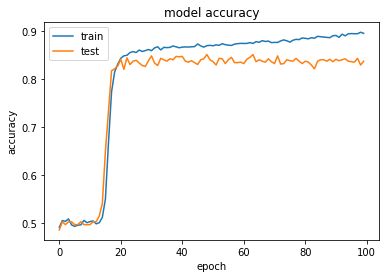

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [56]:
predict_results = model.predict(([input_test, queries_test]))

In [60]:
test_data[0]

(['Mary',
  'got',
  'the',
  'milk',
  'there',
  '.',
  'John',
  'moved',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'John', 'in', 'the', 'kitchen', '?'],
 'no')

In [61]:
predict_results[0]

array([1.33439702e-20, 1.61223867e-20, 1.44818710e-20, 1.40011757e-20,
       1.66986973e-20, 1.10844634e-20, 1.13837000e-20, 1.25420533e-20,
       1.16911026e-20, 1.36195159e-20, 1.62792990e-20, 1.22839940e-20,
       1.66975502e-20, 1.73411275e-20, 1.18130415e-20, 1.46754006e-20,
       5.50589732e-07, 1.44860150e-20, 1.12693746e-20, 1.51089369e-20,
       1.63574223e-20, 1.49957037e-20, 1.35580379e-20, 9.99999404e-01,
       1.43944080e-20, 1.59851474e-20, 1.70485882e-20, 1.53875498e-20,
       1.25732382e-20, 1.42133088e-20, 1.56460954e-20, 1.10312718e-20,
       1.42485415e-20, 1.36893125e-20, 1.77668557e-20, 1.54249280e-20,
       1.60280122e-20, 1.43315633e-20], dtype=float32)

In [62]:
valmax = np.argmax(predict_results[0])

In [64]:
for key, val in tokenizer.word_index.items():
    if val == valmax:
        k = key

In [65]:
k

'no'

In [66]:
predict_results[0][valmax]

0.9999994

In [67]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_ques = "Is the football in the garden ?"

In [68]:
my_data = [(my_story.split(), my_ques.split(), 'yes')]

In [69]:
my_data

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [70]:
my_story, my_ques, my_answer = vectorize_stories(my_data)

In [71]:
my_result = model.predict([my_story, my_ques])

In [72]:
valmax = np.argmax(my_result[0])

In [73]:
for key, val in tokenizer.word_index.items():
    if val == valmax:
        k = key

In [74]:
k

'yes'

In [76]:
my_result[0][valmax]

0.94849336